In [29]:
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms.v2.functional as F
from torchvision.tv_tensors import Image, Mask, BoundingBoxes
from torch.utils.data import Dataset, Subset, DataLoader

from torchvision.ops.boxes import masks_to_boxes

import matplotlib.pyplot as plt
import pandas as pd
import os
# from PIL import Image

In [24]:
# data paths
label_images_path = "/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic"
og_images_path = "/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images"
class_dict = "/kaggle/input/semantic-drone-dataset/class_dict_seg.csv"

In [25]:
class_df = pd.read_csv(class_dict)
n_classes = class_df["name"].nunique()
print(f"the dataset has {n_classes} classes")

the dataset has 24 classes


In [26]:
# add image id to the class_dict
images_list = os.listdir(label_images_path)

image_names = []
for image in images_list:
    name = image.split(".")[0]
    image_names.append(name)
    
df = pd.DataFrame({"id":image_names})

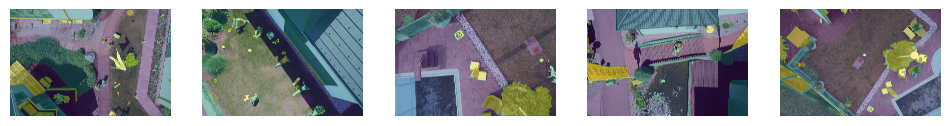

In [27]:
## plot random images
random_sample = torch.randperm(len(image_names)).tolist()[:5]

fig, axs = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12, 20), dpi=100)

for i, idx in enumerate(random_sample):
    img_path = os.path.join(og_images_path, df["id"][idx] + ".jpg")
    mask_path = os.path.join(label_images_path, df["id"][idx] + ".png")
    img = read_image(img_path)
    mask = read_image(mask_path)
    axs[i].imshow(img.permute(1,2,0))
    axs[i].imshow(mask.permute(1,2,0), alpha=0.4, cmap="viridis")
    axs[i].axis(False)
plt.show()

In [51]:
# dataset handler
class DatasetHandler(Dataset):
    def __init__(self, mask_path: str, image_path:str, img_ids:pd.core.frame.DataFrame, transforms=None):
        super().__init__()
        self.img_path = image_path
        self.mask_path = mask_path

        ## CLAUDE !!
        self.img_ids = img_ids.reset_index(drop=True)  # Reset index to ensure alignment

        
        self.transforms = transforms
        self.images = os.listdir(self.img_path)
        self.labels = os.listdir(self.mask_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        ## !! CLAUDE
        if torch.is_tensor(idx):
            idx = idx.item()
        
        img = read_image(os.path.join(self.img_path, self.img_ids["id"][idx] + ".jpg"))
        masks = read_image(os.path.join(self.mask_path, self.img_ids["id"][idx] + ".png"))

        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = Image(img)

        target = {}
        target["boxes"] = BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target




# transforms function
def transforms(img, target):
    # img = Image(img)
    # mask = Mask(mask)

    # apply transforms
    img_trans = F.hflip(img)
    target["masks"] = F.hflip(target["masks"])
    target["boxes"] = F.hflip(target["boxes"])
    

    return img_trans, target

In [56]:
# dataset
dataset = DatasetHandler(mask_path=label_images_path, image_path=og_images_path, img_ids=df, transforms=transforms)

samples = torch.randperm(len(dataset))

train_split = int(len(samples) * 0.8)
train_dataset = Subset(dataset, indices=samples[:train_split])
test_dataset = Subset(dataset, indices=samples[train_split:])

# dataloaders
BATCH_SIZE = 8
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [57]:
for images, target in train_dataloader:
    break

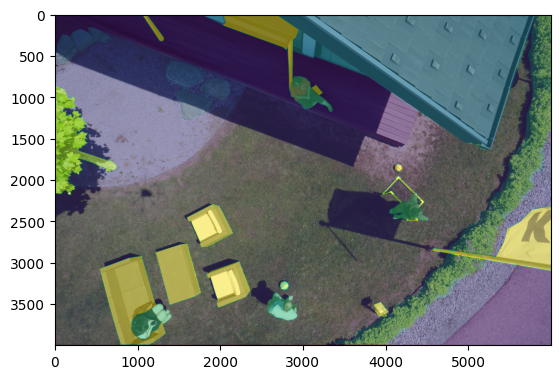

In [65]:
plt.imshow(images[1].permute(1,2,0))
plt.imshow(target["masks"][1].permute(1,2,0), alpha=0.5, cmap="viridis")